In [1]:
# Environment setup
import pandas as pd
import numpy as n
import json
from sklearn.model_selection import train_test_split
from datetime import date, datetime

import sys
sys.path.append('/Users/kleomeniskogias/Visual Studio codee/Mycodes')

from src.helpful_functions import read_json_as_dict
from src.one_hot_encoding import encode_categorical_variable, join_to_df
from src.classification_class import CustomClassifier

/Users/kleomeniskogias/opt/anaconda3/envs/outra_kernel/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Universe
The universe is US residents living in housing units and members of the Armed Forces living in civilian housing units on a military base or in a household not on a military base.

TODO
1. Correlation between input variables
2. Cleaning of data
3. oversampling
4. How can I identify who is in the armed forces? (full or part time employment stat)


In [2]:
# Configurations
columns_type = read_json_as_dict("config/features_type.json")

In [3]:
# Read training data
training_data = pd.read_csv("data/Input/census_income_learn.csv", index_col=False, header=None)
print(training_data.shape)

# Delete the weighting column
training_data  = training_data.drop(training_data.iloc[:,24:25], axis = 1)
training_data.shape

# Read test dataset
test_data = pd.read_csv("data/Input/census_income_test.csv", index_col=False, header=None)
test_data = test_data.drop(test_data.iloc[:,24:25], axis = 1)
print(test_data.shape)

(199523, 42)
(99762, 41)


# Data Cleaning

In [4]:
# Drop duplicates - There is no user id in order to know whether it is the same user or not
training_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

print(training_data.shape, test_data.shape)


(152896, 41) (78864, 41)


In [5]:
# Add a user_id with the assumption that one submision belongs to a distinct user
training_data['user_id'] = list(range(0, training_data.shape[0] ))
training_data = training_data.set_index('user_id')

test_data['user_id'] = list(range(training_data.shape[0], test_data.shape[0] + training_data.shape[0] ))
test_data = test_data.set_index('user_id')

In [6]:
X_data = training_data.loc[:, 0:40]
X_data.columns = list(columns_type.keys())
X_data

y = training_data.loc[:, 41]
print(X_data.shape, y.shape)

(152896, 40) (152896,)


# Data Checking

In [91]:
# If they are 'children' they should not have an income
full_dataset = X_data.join(y)
full_dataset[full_dataset['education'] == ' Children']['Label'].value_counts()

0    12710
Name: Label, dtype: int64

# Data Visualisation

<AxesSubplot: ylabel='Frequency'>

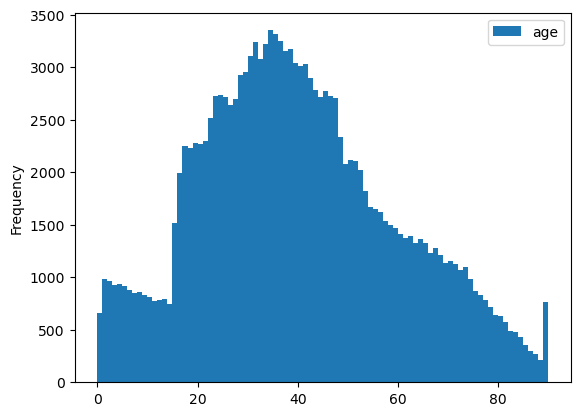

In [ ]:
X_data[['age']].plot.hist(bins = X_data.age.max())

<AxesSubplot: title={'center': 'Gender Distributions'}, ylabel='age'>

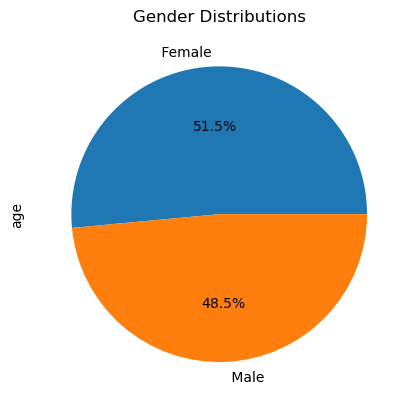

In [ ]:
X_data.groupby(['sex'])['age'].count().plot.pie(autopct='%1.1f%%', title = "Gender Distributions")

# Feature Engineering

In [98]:
no_wage_df['education'].value_counts()

 High school graduate                      39207
 Some college but no degree                23669
 Bachelors degree(BA AB BS)                18298
 Children                                  12710
 Masters degree(MA MS MEng MEd MSW MBA)     6250
 7th and 8th grade                          6082
 10th grade                                 6012
 11th grade                                 5669
 Associates degree-occup /vocational        4694
 9th grade                                  4684
 Associates degree-academic program         3913
 5th or 6th grade                           3017
 12th grade no diploma                      1917
 Prof school degree (MD DDS DVM LLB JD)     1754
 1st 2nd 3rd or 4th grade                   1694
 Doctorate degree(PhD EdD)                  1247
 Less than 1st grade                         777
Name: education, dtype: int64

In [99]:
# Wages exploration
# Wages per hour == 0 means either 'Children' or 'Armed Forces' (can not find it) or out of universe (they are not paid hourly)
no_wage_df = full_dataset[full_dataset['wage per hour'] == 0]
print("Submissions with wage per hour : {}".format(no_wage_df.shape[0]))
print("Submissions that are children : {}".format(no_wage_df[no_wage_df['education'] == ' Children'].shape[0]))
full_dataset[full_dataset['wage per hour'] == 0]['Label'].value_counts()
full_dataset[(full_dataset['wage per hour'] == 0) & (full_dataset['Label'] == 1)]

Submissions with wage per hour : 141594
Submissions that are children : 12710


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,alternative_income_sources,Label
user_id,,,,,,,,,,,,,,,,,,,,,
57,42,Self-employed-incorporated,37,2,Some college but no degree,0,Not in universe,Married-civilian spouse present,Business and repair services,Executive admin and managerial,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,0,1
64,47,Private,31,33,12th grade no diploma,0,Not in universe,Married-civilian spouse present,Utilities and sanitary services,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,0,1
68,33,Private,30,33,Associates degree-occup /vocational,0,Not in universe,Separated,Communications,Precision production craft & repair,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,7556,1
80,58,Self-employed-not incorporated,35,17,Prof school degree (MD DDS DVM LLB JD),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Sales,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,0,1
88,54,Not in universe,0,0,High school graduate,0,Not in universe,Married-civilian spouse present,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152857,48,Self-employed-not incorporated,35,2,Bachelors degree(BA AB BS),0,Not in universe,Married-spouse absent,Finance insurance and real estate,Executive admin and managerial,...,Cuba,Jamaica,Foreign born- U S citizen by naturalization,0,Not in universe,2,50,94,0,1
152867,56,Private,31,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Utilities and sanitary services,Executive admin and managerial,...,?,United-States,Native- Born in the United States,0,Not in universe,2,52,95,0,1
152876,59,Private,24,2,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Manufacturing-nondurable goods,Executive admin and managerial,...,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,0,1


<AxesSubplot: ylabel='Frequency'>

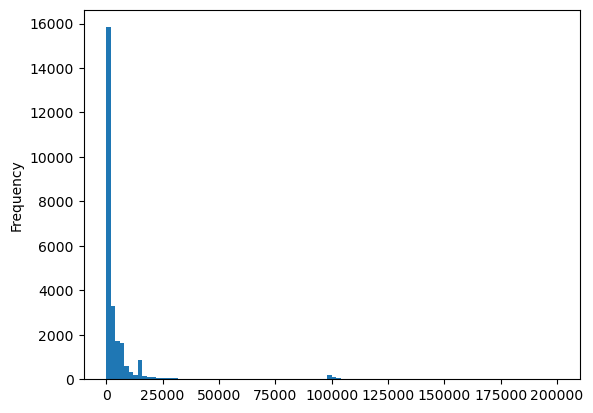

In [89]:
full_dataset[full_dataset['alternative_income_sources'] > 0]['alternative_income_sources'].plot.hist(bins = 100)

In [90]:
full_dataset[(full_dataset['wage per hour'] == 0) & (full_dataset['alternative_income_sources'] > 50000)]['Label'].value_counts()

1    393
0     47
Name: Label, dtype: int64

In [59]:
a = X_data.reset_index().groupby(['education', 'age'])['user_id'].count()
a

education                    age
 10th grade                  15     160
                             16     851
                             17     832
                             18     220
                             19     112
                                   ... 
 Some college but no degree  86      38
                             87      22
                             88      18
                             89      19
                             90      67
Name: user_id, Length: 1198, dtype: int64

In [9]:
# Mappings
industry_codes_dict = read_json_as_dict("config/detailed_industry_code.json")
industry_codes_dict = {int(k) : v for k,v in industry_codes_dict.items()} # Code 52 seems that is not used
own_business_code = {0 : 'niu', 1 : 'yes', 2 : 'no'}

In [10]:
# Identify non-universe 1 year ago
# Civilians / military
# Age distribution
# Group together similar variables

In [11]:
X_data['class of worker'].value_counts()

 Private                           71738
 Not in universe                   54165
 Self-employed-not incorporated     8321
 Local government                   7726
 State government                   4221
 Self-employed-incorporated         3259
 Federal government                 2920
 Never worked                        383
 Without pay                         163
Name: class of worker, dtype: int64

In [12]:
X_data['detailed industry recode'].value_counts().reset_index().sort_values('index')

,index,detailed industry recode
0,0,54548
30,1,826
14,2,2127
34,3,563
3,4,5943
37,5,553
36,6,554
43,7,422
38,8,550
26,9,992


In [13]:
X_data['detailed occupation recode'].value_counts().reset_index().sort_values('index')

,index,detailed occupation recode
0,0,54548
40,1,544
1,2,8749
12,3,3190
26,4,1364
32,5,855
42,6,441
37,7,731
18,8,2137
36,9,738


In [14]:
# Missing values

print(X_data[X_data['hispanic origin'] == ' NA'].shape[0])
print(X_data[X_data['state of previous residence'] == ' ?'].shape[0])

# Missing values for the same 74944 people
print(X_data[X_data['migration code-change in msa'] == ' ?'].shape[0])
print(X_data[X_data['migration code-change in reg'] == ' ?'].shape[0])
print(X_data[X_data['migration code-move within reg'] == ' ?'].shape[0])
print(X_data[X_data['migration prev res in sunbelt'] == ' ?'].shape[0])

# Country of birth
print(X_data[X_data['country of birth father'] == ' ?'].shape[0])
print(X_data[X_data['country of birth mother'] == ' ?'].shape[0])
print(X_data[X_data['country of birth self'] == ' ?'].shape[0])

848
698
74944
74944
74944
74944
6383
5810
3322


In [15]:
X_data[['weeks worked in year', 'wage per hour']].head(30)

,weeks worked in year,wage per hour
user_id,,
0,0,0
1,52,0
2,0,0
3,0,0
4,0,0
5,52,1200
6,52,0
7,30,0
8,52,876


In [16]:
# Similar group of questions
['live in this house 1 year ago', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg'] # migration to another area (Metropolitan area), within area moves, region of preious residence


['live in this house 1 year ago',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg']

In [17]:
X_data['live in this house 1 year ago'].value_counts()

 Not in universe under 1 year old    75288
 Yes                                 62204
 No                                  15404
Name: live in this house 1 year ago, dtype: int64

In [18]:
X_data['migration code-change in msa'].value_counts()

 ?                   74944
 Nonmover            62204
 MSA to MSA          10299
 NonMSA to nonMSA     2759
 MSA to nonMSA         784
 NonMSA to MSA         615
 Abroad to MSA         450
 Not identifiable      424
 Not in universe       344
 Abroad to nonMSA       73
Name: migration code-change in msa, dtype: int64

In [19]:
# Country of birth
X_data[['country of birth self']].value_counts().head(5)

country of birth self
 United-States           130943
 Mexico                    5379
 ?                         3322
 Puerto-Rico               1388
 Philippines                837
dtype: int64

In [20]:
X_data[X_data['country of birth self'] == ' ?'].groupby(['country of birth father', 'country of birth mother'])['country of birth self'].count()

country of birth father  country of birth mother
 ?                        ?                         2746
                          Cambodia                     1
                          Canada                       1
                          China                        1
                          Columbia                     6
                                                    ... 
 Vietnam                  Vietnam                      2
 Yugoslavia               ?                            1
                          Hungary                      1
                          Poland                       1
                          Yugoslavia                   2
Name: country of birth self, Length: 126, dtype: int64

## Create new columns

In [110]:
# Create new columns
capital_fields = X_data[['capital gains', 'capital losses', 'dividends from stocks']].join(y)
X_data['alternative_income_sources'] = X_data['capital gains'] + X_data['dividends from stocks'] - X_data['capital losses']
X_data['unemployment_flag'] = X_data['reason for unemployment'].apply(lambda x : 0 if x == ' Not in universe' else 1)

In [22]:
# Save data distribution to a file
with open('data_distribution.txt', 'w') as f:
    for i, col in enumerate(X_data.columns):
        print(f"------------------ {i, col} ----------------------", file = f)
        print (X_data[[col]].value_counts(), file=f)

# Classification

<AxesSubplot: title={'center': 'Labels Percentages'}, ylabel='Label'>

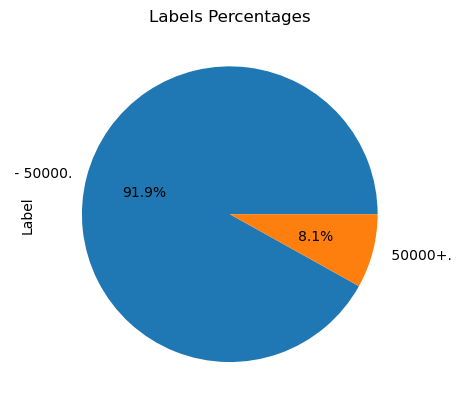

In [23]:
y.name = "Label"
y.value_counts().plot.pie(autopct='%1.1f%%', title = "Labels Percentages")

In [24]:
y.value_counts()

 - 50000.    140529
 50000+.      12367
Name: Label, dtype: int64

In [25]:
y = y.apply(lambda x : 0 if x == ' - 50000.' else 1)

In [26]:
continuous_variables = []
encoded_variables = []
for key, value in columns_type.items():
    if value == 'continuous':
        continuous_variables.append(key)
    else:
        encoded_variables.append(key)

In [27]:
# One Hot Encode Categorical Variables
all_encoded_data = pd.DataFrame()
for col in encoded_variables:
    encoded_data = encode_categorical_variable(input_df=X_data.reset_index(), col_name = col, id_col = 'user_id')
    all_encoded_data = join_to_df(encoded_data, all_encoded_data)

all_encoded_data 

,class of worker_ Federal government,class of worker_ Local government,class of worker_ Never worked,class of worker_ Not in universe,class of worker_ Private,class of worker_ Self-employed-incorporated,class of worker_ Self-employed-not incorporated,class of worker_ State government,class of worker_ Without pay,detailed industry recode_0,...,own business or self employed_1,own business or self employed_2,fill inc questionnaire for veteran's admin_ No,fill inc questionnaire for veteran's admin_ Not in universe,fill inc questionnaire for veteran's admin_ Yes,veterans benefits_0,veterans benefits_1,veterans benefits_2,year_94,year_95
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,1
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152891,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,1
152892,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,1
152893,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [28]:
all_encoded_data.sum().reset_index().sort_values(0).head(20)

,index,0
300,detailed household and family stat_ Other Rel ...,1
280,detailed household and family stat_ Child <18 ...,2
288,detailed household and family stat_ Grandchild...,2
287,detailed household and family stat_ Grandchild...,2
304,detailed household and family stat_ Other Rel ...,3
303,detailed household and family stat_ Other Rel ...,4
19,detailed industry recode_10,4
284,detailed household and family stat_ Grandchild...,6
299,detailed household and family stat_ Other Rel ...,6
276,detailed household and family stat_ Child <18 ...,9


In [29]:
# Build the dataset that is going to be used for the classification purpose
X = (X_data[continuous_variables].join(all_encoded_data))
valid_column_names = [col.replace('<', 'less than ') for col in X.columns ]
X.columns = valid_column_names
print(X.shape, y.shape)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(152896, 510) (152896,)
(107027, 510) (107027,) (45869, 510) (45869,)


In [30]:
for col in X.columns:
    if '<' in col:
        print(col)

In [31]:
# Random Forest
print(" --------------------- RF --------------------")
classifiers_outputs_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp = {}
rf = CustomClassifier("RF")
rf.set_train_and_test_data(X_train, X_val, y_train, y_val)
rf.fit_model()
rf.estimate_accuracy()
rf.estimate_precision()
rf.estimate_f1_score()
rf.estimate_training_accuracy()

# Logistic Regression
print(" --------------------- LR --------------------")
lr = CustomClassifier("LR")
lr.set_train_and_test_data(X_train, X_val, y_train, y_val)
lr.fit_model()

lr.estimate_accuracy()
lr.estimate_precision()
lr.estimate_f1_score()
lr.estimate_training_accuracy()

# XGBoost
print(" --------------------- XGB --------------------")
xgb = CustomClassifier("XGBoost")
xgb.set_train_and_test_data(X_train, X_val, y_train, y_val)
xgb.fit_model()
xgb.estimate_accuracy()
xgb.estimate_precision()
xgb.estimate_f1_score()
xgb.estimate_training_accuracy()

 --------------------- RF --------------------
RF
Accuracy of RF classifier on test set: 0.9385
Precision of RF classifier on test set: 0.7327
F1-score (unweighted) of RF classifier on test set: 0.7337
F1-score (weigthed) of RF classifier on test set: 0.9294
Accuracy of RF classifier on training set: 0.9996
 --------------------- LR --------------------
LR


/Users/kleomeniskogias/opt/anaconda3/envs/outra_kernel/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of LR classifier on test set: 0.9281
Precision of LR classifier on test set: 0.7442
F1-score (unweighted) of LR classifier on test set: 0.6209
F1-score (weigthed) of LR classifier on test set: 0.9068
Accuracy of LR classifier on training set: 0.9284
 --------------------- XGB --------------------
XGBoost


/Users/kleomeniskogias/opt/anaconda3/envs/outra_kernel/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/outra_kernel/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:54:57] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost classifier on test set: 0.9449
Precision of XGBoost classifier on test set: 0.7516
F1-score (unweighted) of XGBoost classifier on test set: 0.7776
F1-score (weigthed) of XGBoost classifier on test set: 0.9392
Accuracy of XGBoost classifier on training set: 0.9531


0.9531

In [32]:
def save_dataframe_to_csv(dataframe, filename):
    dataframe.to_csv(filename)

def get_date_timestamp():
    ts = datetime.now()
    return ts.strftime("%d/%m/%Y, %H:%M")

def save_model_performance_in_dataframe(version, running_date = get_date_timestamp(), classifiers_list = [rf, lr, xgb], save_flag = 1):
    # Create a dataframe with the resutls
    column_names = []
    for classifier in classifiers_list:
        column_names.append(classifier.model) # ["RF", "LR", "XGBoost"]
    # Populate dataframe
    classifiers_outputs_temp = pd.DataFrame(columns = column_names, index = ["Accuracy" , "Precision", "F1_score unweighted", "F1_score weighted", "Training Accuracy", "Version", "Date"])
    for classifier in classifiers_list:
        classifiers_outputs_temp.loc['Training Accuracy', classifier.model] = round(classifier.training_accuracy, 3)
        classifiers_outputs_temp.loc['Accuracy', classifier.model] = round(classifier.accuracy, 3)
        classifiers_outputs_temp.loc['Precision', classifier.model] = round(classifier.precision, 3)
        classifiers_outputs_temp.loc['F1_score unweighted', classifier.model] = round(classifier.f1_score_macro, 3)
        classifiers_outputs_temp.loc['F1_score weighted', classifier.model] = round(classifier.f1_score_weighted, 3)
        classifiers_outputs_temp.loc['Version', classifier.model] = version
        classifiers_outputs_temp.loc['Date', classifier.model] = running_date
    classifiers_outputs_temp = classifiers_outputs_temp.T
    classifiers_outputs_temp = classifiers_outputs_temp.reset_index().rename(columns = {'index' : 'Model'}).set_index('Date')
    # print(classifiers_outputs_temp)
    # If there is a csv file get the CSV
    try:
        classifiers_outputs = pd.read_csv("data/Processing/model_performance.csv").set_index('Date')
    except:
        print("The classifier_outputs csv does not exist")
        print("Creating the classifiers output pandas dataframe...")
        classifiers_outputs = classifiers_outputs_temp
    else:
        classifiers_outputs = classifiers_outputs.append(classifiers_outputs_temp)


    if save_flag:
        save_dataframe_to_csv(classifiers_outputs, "./data/Processing/model_performance.csv")

    return classifiers_outputs_temp

In [33]:
# save_model_performance_in_dataframe(version = 'Basic Implementation', running_date=datetime(2022, 12, 28, 20, 55).strftime("%d/%m/%Y, %H:%M") , save_flag=1)
classifiers_output = save_model_performance_in_dataframe(version = 'Basic Implementation', save_flag=0)

/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_62140/311502982.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classifiers_outputs = classifiers_outputs.append(classifiers_outputs_temp)


In [34]:
classifiers_output

,Model,Accuracy,Precision,F1_score unweighted,F1_score weighted,Training Accuracy,Version
Date,,,,,,,
"06/01/2023, 23:55",RF,0.938,0.733,0.734,0.929,1.0,Basic Implementation
"06/01/2023, 23:55",LR,0.928,0.744,0.621,0.907,0.928,Basic Implementation
"06/01/2023, 23:55",XGBoost,0.945,0.752,0.778,0.939,0.953,Basic Implementation


In [159]:
# # Results formatted
# classifiers_list = [rf, lr, xgb]
# version = 'Basic Implementation'
# running_date = '2022-12-28'
# column_names = []
# for classifier in classifiers_list:
#     column_names.append(classifier.model) # ["RF", "LR", "XGBoost"]
# classifiers_outputs = pd.DataFrame(columns = column_names, index = ["Accuracy" , "Precision", "F1_score unweighted", "F1_score weighted", "Training Accuracy", "Version", "Date"])
# for classifier in classifiers_list:
#     classifiers_outputs.loc['Training Accuracy', classifier.model] = round(classifier.training_accuracy, 3)
#     classifiers_outputs.loc['Accuracy', classifier.model] = round(classifier.accuracy, 3)
#     classifiers_outputs.loc['Precision', classifier.model] = round(classifier.precision, 3)
#     classifiers_outputs.loc['F1_score unweighted', classifier.model] = round(classifier.f1_score_macro, 3)
#     classifiers_outputs.loc['F1_score weighted', classifier.model] = round(classifier.f1_score_weighted, 3)
#     classifiers_outputs.loc['Version', classifier.model] = version
#     classifiers_outputs.loc['Date', classifier.model] = running_date

# classifiers_outputs.T#.to_clipboard()